/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2.13.0


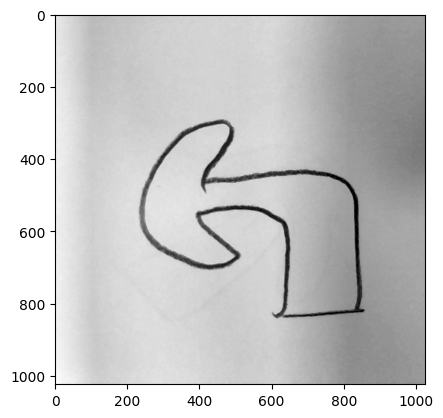

Found 393 files belonging to 3 classes.
Using 276 files for training.
Found 393 files belonging to 3 classes.
Using 117 files for validation.
['L', 'R', 'U']
(24, 300, 300, 3)
(24,)
0.0 1.0
50095040/50095040 [==============================] - 0s 0us/step
Model: "efficientnetb3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 300, 300, 3)]        0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, 300, 300, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 300, 300, 3)          7         ['rescaling_1[0][0]']         
 on)                        

/opt/conda/lib/python3.10/site-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-12-06 12:45:08.461210: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inefficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


12/12 [==============================] - 83s 1s/step - loss: 2.2856 - accuracy: 0.6558 - val_loss: 0.7722 - val_accuracy: 0.8034
Epoch 2/30
12/12 [==============================] - 9s 744ms/step - loss: 0.1665 - accuracy: 0.9674 - val_loss: 0.4410 - val_accuracy: 0.8462
Epoch 3/30
12/12 [==============================] - 9s 720ms/step - loss: 0.0656 - accuracy: 0.9855 - val_loss: 1.1240 - val_accuracy: 0.9145
Epoch 4/30
12/12 [==============================] - 9s 723ms/step - loss: 0.1338 - accuracy: 0.9674 - val_loss: 0.3968 - val_accuracy: 0.8718
Epoch 5/30
12/12 [==============================] - 9s 729ms/step - loss: 0.1013 - accuracy: 0.9746 - val_loss: 1.2761 - val_accuracy: 0.8120
Epoch 6/30
12/12 [==============================] - 9s 730ms/step - loss: 0.0195 - accuracy: 0.9964 - val_loss: 0.2424 - val_accuracy: 0.9402
Epoch 7/30
12/12 [==============================] - 9s 736ms/step - loss: 0.0206 - accuracy: 0.9964 - val_loss: 0.3125 - val_accuracy: 0.9573
Epoch 8/30
12/12 [=

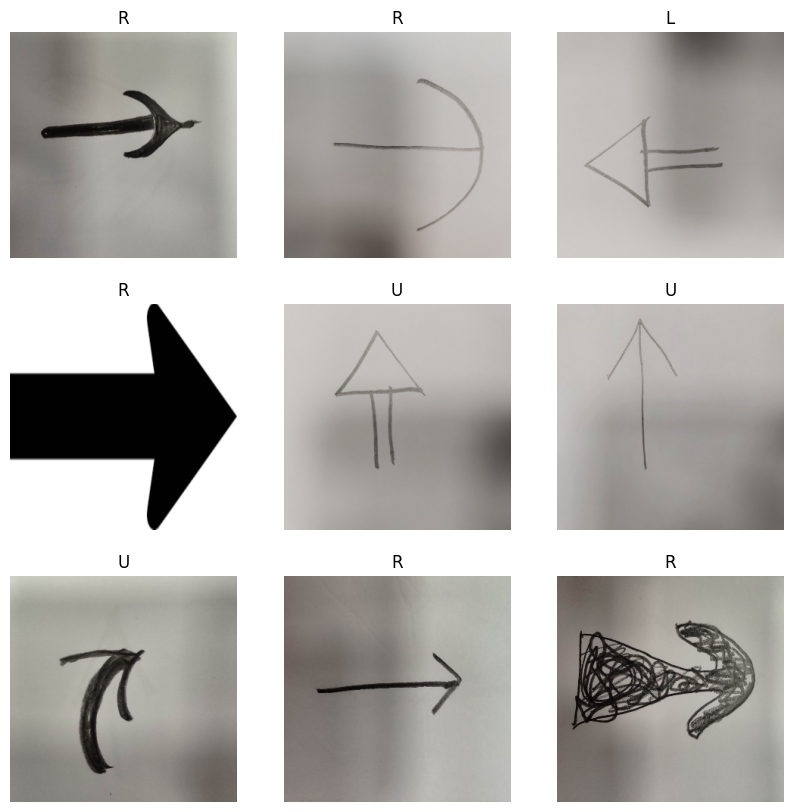

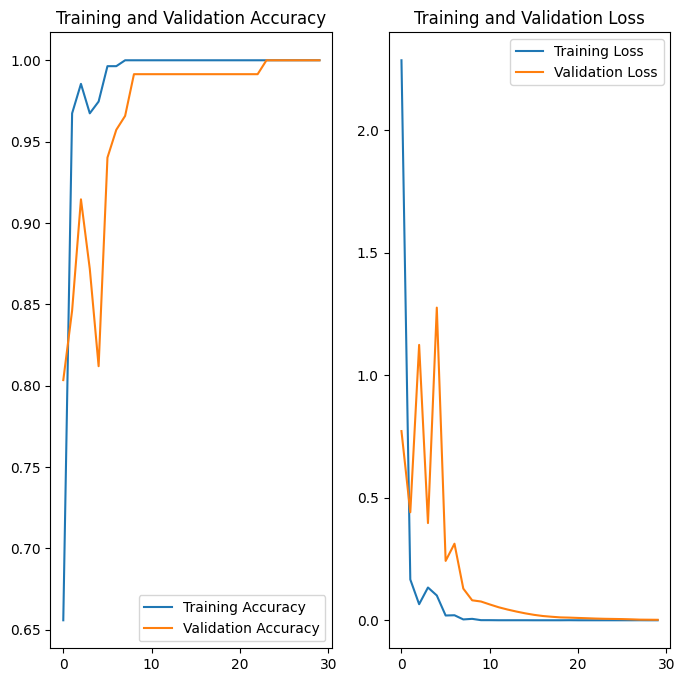

In [1]:
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import cv2
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

print(tf.__version__)

DATADIR = "/kaggle/input/cnndataset"
CATEGORIES = ["L", "R", "U"]

for category in CATEGORIES:
    path = os.path.join(DATADIR, category)  # path to right,up and left arrows dir
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        plt.imshow(img_array, cmap="gray")
        plt.show()
        break
    break

# Batch - Size - Width
batch_size = 24
img_height = 300
img_width = 300

# Train And Validation
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATADIR,
    validation_split=0.3,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATADIR,
    validation_split=0.3,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.Rescaling(1. / 255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Pixel değerleri [0,1] aralığında !
print(np.min(first_image), np.max(first_image))

num_classes = len(class_names)

model = tf.keras.applications.EfficientNetB3(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax", )

model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

epochs = 30
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

model.save('/kaggle/working/efficient_model')